# Machine Learning and Statistics for Physicists

## Homework 8

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import inspect

### Problem 1

The default score function used by sklearn to evaluate how well a regression model predicts data is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$. Implement the function below to calculate $R^2$:

In [3]:
def calculate_R2(y_data, y_pred):
    """Calculate the coefficient of determination R2 for two arrays.
    
    Parameters
    ----------
    y_data : array
        Array of data values, must have the same shape as y_pred.
    y_pred : array
        Array of predicted values, must have the same shape as y_data.
        
    Returns
    -------
    float
        Calculated coefficient of determination R2.
    """
    assert y_data.shape == y_pred.shape
    # YOUR CODE HERE
    stot = np.sum((y_data-np.mean(y_data))**2 )
    sres = np.sum((y_data - y_pred)**2)
    return 1- (sres/stot)
    raise NotImplementedError()

In [4]:
# A correct solution should pass the tests below.
gen = np.random.RandomState(seed=123)
N = 100
x = gen.uniform(size=N)
y_pred = 2 * x - 1
y_data = y_pred + gen.normal(scale=0.1, size=N)
assert np.round(calculate_R2(y_data, y_pred), 3) == 0.961
assert np.round(calculate_R2(y_data, -y_pred), 3) == -2.935
assert np.round(calculate_R2(y_pred, y_pred), 3) == 1.000
assert np.round(calculate_R2(y_pred, -y_pred), 3) == -3.000
# Check that predicting the mean has R2 = 0
assert np.round(calculate_R2(y_data, np.full(N, np.mean(y_pred))), 3) == 0.000

### Problem 2

In this exercise, you will implement the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) technique for automatically calculating the gradients needed for efficient optimization in machine learning.  You would normally use a framework like TensorFlow or PyTorch for these calculations, but the purpose of this exercise is to gain some insight into how the magic happens.

Any mathematical function can be represented as a computational graph. For example,
$$
F(x) = 1 + 2 x
$$
could be represented by a graph with input nodes $(1, 2, x)$, two internal nodes for the operations $(+, \times)$, and an output node $F$.

Working at a higher level of abstraction, a function:
$$
F(x, y, z) = f\bigl(x, g(h(y), z)\bigr)
$$
has input nodes $(x, y, z)$, internal nodes $(f, g, h)$ and an output node $F$. In general, the information flowing between nodes can be aribtrary tensors.

An important feature of the graph representation is that the calculations required to flow the inputs $(x, y, z)$ forward to the output $y$ are naturally decomposed into localized steps associated with each node.  For example, the $g$ node can calculate its output $g(h(y))$ knowing only the value of its input $h(y)$ and not caring how this input was obtained or where its ouptut will flow.

The key insight of the [backpropagation algorithm](https://en.wikipedia.org/wiki/Backpropagation) is that the calculation of partial derivatives can also be localized using the chain rule. For example, the $h$ node can propagate partial derivatives of the output $y$ back to its input $y$ using
$$
\frac{\partial F}{\partial y}(x, y, z) = \frac{\partial F}{\partial h}(x, z) \frac{\partial h}{\partial y}(y)
$$
knowing only the value of $\frac{\partial F}{\partial h}(x, z)$ and not caring how this was obtained, or how $\frac{\partial F}{\partial y}$ will be used. Note however that this calculation flows **backwards** through the graph, since it requires the value of $\frac{\partial F}{\partial h}(x, z)$ calculated by its output node $g$.

When $F$, $y$ and $h$ are arbitrary tensors with (flattened) indices $\mu$, $\nu$ and $\alpha$, respectively, the corresponding tensor chain rule is:
$$
\frac{\partial F_\mu}{\partial y_\nu}(x, y, z) = \sum_\alpha \frac{\partial F_\mu}{\partial h_\alpha}(x, z) \frac{\partial h_\alpha}{\partial y_\nu}(y)
$$
Note that in both the forward and backward directions, we only ever do calculations with (tensors) of floating-point numbers, not abstract variables.

With a base class to represent an arbitrary graph node, we can implement almost all of the logic required for forward and backward passes through a graph in a completely generic way:

In [5]:
class GraphNode(object):
    """A generic graph node for forward and backward compuation.
    """
    def __init__(self, **input_nodes):
        """Initialize a generic graph node.
        """
        self.name = self.__class__.__name__
        self.input_nodes = input_nodes
        self.input_grads = {inp: None for inp in self.input_nodes}
        # Check that our input node names match the args defined for compute().
        compute_args = set(inspect.signature(self.compute).parameters)
        if set(input_nodes) != compute_args:
            raise ValueError(
                f'Input names {set(input_nodes)} do not match compute args {compute_args}.')
        
    def forward(self, verbose=False):
        """Perform a forward pass through the graph, flowing input values to output values.
        """
        input_values = {inp: node.forward(verbose) for inp, node in self.input_nodes.items()}
        self.input_shapes = {inp: value.shape for inp, value in input_values.items()}
        self.value = self.compute(**input_values)
        if verbose:
            print(self.name, 'forward:', input_values, '->', self.value)
        return self.value
    
    def backward(self, verbose=False, grad_in=None):
        """Perform a backward pass through the graph, flowing output gradients to input gradients.
        """
        if not hasattr(self, 'value'):
            raise ValueError('Must call forward() before backward().')
        if grad_in is None:
            grad_in = np.ones(self.value.shape)
        elif grad_in.shape != self.value.shape:
            raise ValueError(f'Input grad has shape {grad_in.shape} but expected {self.value.shape}.')
        final_shape = tuple(grad_in.shape[:-len(self.value.shape)])
        for inp, node in self.input_nodes.items():
            expected_shape = self.value.shape + self.input_shapes[inp]
            if self.input_grads[inp].shape != expected_shape:
                raise ValueError(f'{self.name} grad wrt "{inp}" should have shape {expected_shape}.')
            grad_out = grad_in.reshape(-1, self.value.size).dot(self.input_grads[inp].reshape(self.value.size, -1))
            grad_out = grad_out.reshape(final_shape + self.input_shapes[inp])
            if verbose:
                print(self.name, 'backward:', grad_out, '<-', grad_in)
            node.backward(verbose=verbose, grad_in=grad_out)

The leaf nodes are a specialized graph node that feed a tensor into the graph (to propagate forward) and store the corresponding gradients wrt the graph output (from back propagation):

In [6]:
class Tensor(GraphNode):
    
    def __init__(self, value):
        self.value = np.asarray(value)
        
    def forward(self, verbose=False):
        return self.value
        
    def backward(self, grad_in, verbose=False):
        self.grad = grad_in

All non-leaf graph nodes inherit from `GraphNode` and implement a `compute` method that:
 - Specifies (arbitrary) variable names for each of its inputs.
 - Computes and stores the backward partial derivatives wrt to each of its inputs.
 - Computes and returns the forward value.

For example, the following function implements $\sin(x)$ element-wise on an arbitrary input 1D tensor (aka vector) $x$:

In [7]:
ELEMENTWISE = lambda z: np.diag(z.reshape(-1)).reshape(z.shape + z.shape)

In [8]:
class Sin(GraphNode):
    
    def compute(self, x):
        self.input_grads['x'] = ELEMENTWISE(np.cos(x))
        return np.sin(x)

Note the use of `ELEMENTWISE` to calculate the full gradient matrix
$$
\frac{\partial \sin x_\mu}{\partial x_\nu} \; .
$$
from its diagonal elements, which is a tensor generalization of the [np.diag](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html) function.

Build a simple graph to see the forward and backward flows in action:

In [9]:
theta = Tensor(np.linspace(0, 2 * np.pi, 25))
sin_theta = Sin(x=theta)

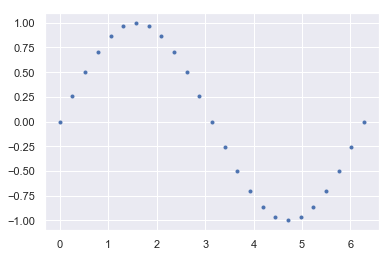

In [10]:
sin_theta.forward()
plt.plot(theta.value, sin_theta.value, '.');

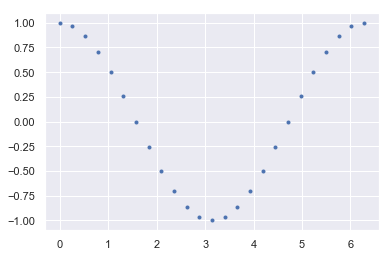

In [11]:
sin_theta.backward()
plt.plot(theta.value, theta.grad, '.');

Implement the compute method below to compute the element-wise [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function):
$$
f(s) = \frac{1}{1 + \exp(-s)}
$$
for an arbitrary input vector $s$. This node is a popular choice of "activation function" to introduce some non-linearity into a neural network.

In [12]:
class Sigmoid(GraphNode):
    
    def compute(self, s):
        # YOUR CODE HERE
        self.input_grads['s'] = ELEMENTWISE(1/(4*np.cosh(s/2)*np.cosh(s/2)))
        return 1/(1+ np.exp(-s))
        raise NotImplementedError()

In [13]:
# A correct solution should pass the tests below.
s = Tensor([-1., 0., +1.])
f = Sigmoid(s=s)
f.forward()
assert np.allclose(f.value, [0.26894142, 0.5, 0.73105858])
assert f.input_grads['s'].shape == (3,3)
f.backward()
assert np.allclose(s.grad, f.value * (1 - f.value))
z = Tensor(np.zeros(10))
f = Sigmoid(s=z)
f.forward()
assert f.value.shape == (10,)
f.backward()
assert z.grad.shape == (10,)
s = Tensor([[-1.], [0.], [+1.]])
f = Sigmoid(s=s)
f.forward()
assert np.allclose(f.value, [[0.26894142], [0.5], [0.73105858]])
assert f.input_grads['s'].shape == (3, 1, 3, 1)
f.backward()
assert np.allclose(s.grad, f.value * (1 - f.value))

Implement the compute method below to compute the linear transformation:
$$
Y(X) = X W + b
$$
where $W$ is an $D\times M$ "weight" matrix, $X$ is a $N\times D$ data matrix ($N$ samples and $D$ features), and $b$ is a vector of length $M$ that is added to each row (i.e., numpy broadcast style). This node is a key building block for a (fully connected) neural network.

Hint: the resulting tensor $Y(X)$ has dimensions $N\times M$, so the gradients with respect to $X$ and $W$ have four dimensions.  For example,
$$
\frac{\partial Y_{nm}}{\partial X_{ab}} = \delta_{na} W_{mb} \; ,
$$
and this gradient tensor has shape (N, M, N, D).

In [14]:
#lambda x: np.np.identity(N)


class Linear(GraphNode):
    
    def compute(self, X, W, b):
        assert len(W.shape) == 2 and len(X.shape) == 2 and len(b.shape) == 1
        M = len(b)
        N, D = X.shape
        assert W.shape == (D, M)
        # YOUR CODE HERE
        gx = np.ones((N,M,N,D))
        
        for i in range(N):
            for k in range(M):
                for j in range(N):
                    for l in range(D):
                        if i==j :
                            gx[i,k,j,l]=W[l,k]
                        else:
                            gx[i,k,j,l]=0
                            
        hx = np.ones((N,M,D,M))
        
        for ii in range(M):
            for jj in range(M):
                for kk in range(N):
                    for ll in range(D):
                        if ii==jj :
                            hx[kk,ii,ll,jj]=X[kk,ll]
                        else:
                            hx[kk,ii,ll,jj]=0
        
        jx = np.zeros((N,M,M))
        for i in range(N):
            for j in range(M):
                jx[i,j,j]=1
            
        '''
        gx = np.diag(np.ones(N))
        gxx = np.zeros((N,M,N,D))
        ia,ib,ic = np.ogrid[:N,:M,:D]
        gxx[ia,ib,ia,ic]+=W[ic,ib]
        gww = np.zeros((N,M,D,M))
        aa,bb,dd= np.ogrid[:N,:M,:D]
        gww[aa,bb,dd,bb]+=X[aa,dd]
        '''

        ic = np.ogrid[:D]
        self.input_grads['X'] = gx
        self.input_grads['W'] = hx
        self.input_grads['b'] = jx
        
        return np.dot(X,W) + b
        
        raise NotImplementedError()


In [15]:
# A correct solution should pass the tests below.
X = Tensor([[-1, 0, 1]])
W = Tensor(np.identity(3))
b = Tensor(np.zeros(3))
Y = Linear(X=X, W=W, b=b)
Y.forward()
assert np.array_equal(Y.value, X.value)
assert Y.input_grads['X'].shape == (1, 3, 1, 3)
assert Y.input_grads['W'].shape == (1, 3, 3, 3)
assert Y.input_grads['b'].shape == (1, 3, 3)
Y.backward()
assert np.array_equal(X.grad, [[1., 1., 1.]])
assert np.array_equal(b.grad, [1., 1., 1.])
assert np.array_equal(W.grad, np.tile([-1., 0., 1.], (3, 1)).T)

W = Tensor(np.arange(12).reshape(3, 4))
X = Tensor(np.ones((2, 3)))
b = Tensor(np.arange(4))
Y = Linear(X=X, W=W, b=b)
Y.forward()
assert np.array_equal(Y.value, np.tile([12., 16., 20., 24.], (2, 1)))
Y.backward()
assert np.array_equal(W.grad, np.full((3, 4), 2.))
assert np.array_equal(b.grad, np.full(4, 2.))
assert np.array_equal(X.grad, np.tile([6., 22., 38.], (2, 1)))

Implement the compute method below to calculate the mean squared difference between arbitrary (but identically shaped) tensors $x$ and $y$,
$$
\text{MSE}(x, y) = \frac{1}{N} \sum_\mu (x_\mu - y_\mu)^2 \; ,
$$
also known as the "mean-squared error (MSE) loss" function when the two vectors are target and predicted values, and related to the "L2 loss". Note that the result is always a 1D tensor of length 1, independent of the shape of $x$ and $y$.

In [16]:
class MSELoss(GraphNode):
    
    def compute(self, target, predicted):
        assert target.shape == predicted.shape
        # YOUR CODE HERE
        dxy = target-predicted
        sq = dxy**2
        dxy1 = np.reshape(dxy,-1)
        N = len(dxy1)
        self.input_grads['target'] = 2*dxy/N
        self.input_grads['predicted']= -2*dxy/N
        return np.mean(sq)
        raise NotImplementedError()

In [17]:
# A correct solution should pass the tests below.
x = Tensor(np.ones(3))
y = Tensor(np.zeros(3))
loss = MSELoss(target=x, predicted=y)
loss.forward()
assert loss.value == 1.
loss.backward()
assert np.allclose(x.grad, +2. / 3.)
assert np.allclose(y.grad, -2. / 3.)

We now have all the building blocks necessary to create a (fully connected) neural network.  Implement the function below to build the graph for a neural network with a single "hidden" (internal) layer. The corresponding function is:
$$
Y(X) = \varphi(X W_1 + b_1)\,W_2 + b_2 \; ,
$$
where $\varphi(s)$ is the (element-wise) sigmoid function and $X$ is a dataset of input values represented by a $N\times D$ matrix.

In [18]:
def build_network(X, W1, b1, W2, b2):
    """Build a neural network with one hidden layer.
    
    Parameters
    ----------
    X, W1, b1, W2, b2: Tensor objects of compatible shapes.
    
    Returns
    -------
    Graph represented by a GraphNode object.
    """
    # YOUR CODE HERE
    ss = Linear(X=X,W=W1,b=b1)
    XX = Sigmoid(s=ss)
    YY = Linear(X=XX,W=W2,b=b2)
    return YY
    
    raise NotImplementedError()

In [19]:
# A correct solution should pass the tests below.
N, D, M = 4, 3, 2
X = Tensor(np.ones((N, D)))
W1 = Tensor(np.ones((D, M)))
b1 = Tensor(np.zeros(M))
W2 = Tensor(np.ones((M, 1)))
b2 = Tensor([0.])
Y = build_network(X, W1, b1, W2, b2)
Y.forward()
assert np.allclose(Y.value, 1.90514825)

Finally, we can use the code developed so far to train a neural network consisting of one input node, 25 hidden nodes, and one output node. First set up the input dataset $X$ and corresponding target output values:

In [20]:
# Input values of theta on a [0,2pi] grid.
n_input = 100
theta = Tensor(np.linspace(0, 2 * np.pi, n_input).reshape(n_input, 1))
sin_theta = Sin(x=theta)

Next declare the model parameters, with values initialized from a unit Gaussian distribution:

In [21]:
# Build a neural network graph with 1 hidden layer.
n_hidden = 25
gen = np.random.RandomState(seed=123)
W1 = Tensor(gen.normal(size=(1, n_hidden)))
b1 = Tensor(gen.normal(size=n_hidden))
W2 = Tensor(gen.normal(size=(n_hidden, 1)))
b2 = Tensor(gen.normal(size=(1,)))

Finally, build the model and define the loss metric we will minimize:

In [22]:
model = build_network(theta, W1, b1, W2, b2)
loss = MSELoss(target=sin_theta, predicted=model)

We can now "learn" to transform $\theta$ into $\sin(\theta)$ using the stochastic gradient descent (SGD) algorithm:

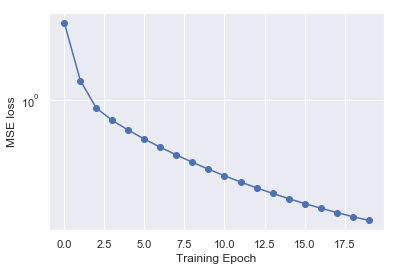

In [23]:
def learn(learning_rate=0.05, n_epochs=20):
    losses = []
    for epoch in range(n_epochs):
        losses.append(loss.forward())
        loss.backward()
        W2.value -= learning_rate * W2.grad
        W1.value -= learning_rate * W1.grad
        b1.value -= learning_rate * b1.grad
        b2.value -= learning_rate * b2.grad
    plt.plot(losses, 'o-')
    plt.yscale('log')
    plt.xlabel('Training Epoch')
    plt.ylabel('MSE loss')
    
learn()

### Problem 3

Use the [redshift case study](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/Redshift.ipynb) as a template for your own case study using your adopted dataset...

This is an open ended assignment, but here are some suggested studies:
 - Define your baseline supervised learning problem. Is it a regression or classification problem?
 - Find a good value of `n_neighbors` for a KNN solution to your problem.
 - Find a good value of `max_depth` for a Decision Tree solution to your problem.
 - What is the most important variable according to the optimum decision tree?
 - Quantify the improvement when using a random forest instead of a single tree.